# Photic Zone: Low-data-rate sensor profile reduction


Profiler sensors produce profiles that can be described approximately with a few parameters. This notebook takes up
this simplification / reduction process starting again with CTD data. See notebook Ocean 01 A for the source material.


In [30]:
import os, sys, time, glob, warnings
from IPython.display import clear_output             # use inside loop with clear_output(wait = True) followed by print(i)
warnings.filterwarnings('ignore')
this_dir = os.getcwd()
data_dir = this_dir + '/../data'

from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors
import numpy as np, pandas as pd, xarray as xr
from numpy import datetime64 as dt64, timedelta64 as td64

# convenience functions abbreviating 'datetime64' and so on
def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D'))
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')
def day_of_month_to_string(d): return str(d) if d > 9 else '0' + str(d)

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))


Jupyter Notebook running Python 3


### to do 

- Review and update code: Use profile time data
- Save the profiles (and load them) using a DataFrame
    - Improve the Profile class
- Bring in kwargs for functions
- Write up re-naming Dataset / DataArray components
- Plotting and Widgets
    - DONE: Animation
        - add sound to charts
    - Triple sliders: Start, number, skip: Left and Right: Asc/Desc/Both
    - 6 by 2: T/Sal, DO/pCO2, Chlor-A/CDOM, Scattering/PAR, pH+ghost/nitrate+ghost
    - filter parameter and ranges as arrays
    - less filter dropout from NaNs
- Extend the time range to all of 2014 - 2021
- Annotate pH stops: both midnight and noon local, include that in the publication
    - are rests are accurately picked up in other time ranges
    - Does a pH descent change the nature of say temp? How do longer dwells show up???
- Derivatives
    - attach the derivative plots to the main data
    - plot zero line for zero crossings in the derivative plots, flag those
- Characterization by (sensor type, ascent/descent, continuous/interval, night/day)...
    - Extract the data with time and depth
    - Smooth the data
    - Calculate first and second derivatives
    - Calculate a set of characterization values
        - Start depth
        - Depth at which signal slope (low pass) changes
        - Inflection
        - Max slope
        - Upper layer thickness
        - Boxcar standard deviation
        - And like that; and infer lenses if they are present
    - Revisit the down-sampling to one minute and the stddev signal
- Dimension is now roughly speaking a collection of profiles by sensors
    - Compare same profile different sensors
    - Compare different profile same sensors
    - Review the Arctic Great Rivers data in the sense of "29-observation axis"

In [31]:
def filter(v, ftype='hat', control1=3):
    """Operate on an XArray data array (with some checks) to produce a filtered version"""
    # pre-checks
    if not v.dims[0] == 'time': return v

    if ftype == 'hat': 
        n_passes = control1        # should be a kwarg
        len_v = len(v)
        for n in range(n_passes):
            source_data = np.copy(v) if n == 0 else np.copy(smooth_data)
            smooth_data = [source_data[i] if i == 0 or i == len_v - 1 else \
                0.5 * source_data[i] + 0.25 * (source_data[i-1] + source_data[i + 1]) \
                for i in range(len_v)]
        return smooth_data
    return v

def pull_data_array_by_name(ds, sensor_name):
    """completely extraneous (Delete Me) function"""
    return ds['sensor_name']

def dydx(y, x):
    """
    This is a simple 'centered' derivative: At location n it uses values at (n-1) and (n+1).
    Endpoints are hardcoded to zero so to do make them proper estimates.
    The sign +- also to do should be handled properly; varies with direction of profile up / down
    """ 
    len_y = len(y)
    return [0. if i == 0 or i == len_y - 1 else -(y[i+1] - y[i-1])/(x[i+1] - x[i-1]) for i in range(len_y)]

def ProfileCrawler(ds, verbose = False):
    """
    Walk a passed dataset to pin profiler start / stop times based on pressure
    """

    s = ds.seawater_pressure.to_series()         # pandas series, just pressure (and times)
    len_s = len(s)

    ascent_starts  = np.zeros(len_s)
    descent_starts = np.zeros(len_s)
    rest_starts    = np.zeros(len_s)
    
    threshold, nA0, nD0, nR0 = 1., 0, 0, 0

    for i in range(1, len_s - 5):         # 6 minute window
        
        # catch ascent
        if s[i-1] - s[i]   <= threshold and  \
           s[i]   - s[i+1] >= threshold and  \
           s[i+1] - s[i+2] >= threshold and  \
           s[i+2] - s[i+3] >= threshold and  \
           s[i+3] - s[i+4] >= threshold and  \
           s[i+4] - s[i+5] >= threshold:
            ascent_starts[i] = True
            nA0 += 1

        # catch descent
        if s[i-1] - s[i]   >= threshold and  \
           s[i]   - s[i+1] <= threshold and  \
           s[i+1] - s[i+2] <= threshold and  \
           s[i+2] - s[i+3] <= threshold and  \
           s[i+3] - s[i+4] <= threshold and  \
           s[i+4] - s[i+5] <= threshold:
            descent_starts[i] = True
            nD0 += 1
        
        # this variant is a little too liberal; false positives ~25%
        # why? Because twice daily there are stops on the way down for pH
        # catch rest
        if i >= 5 and \
           s[i-5] - s[i-4] <= -threshold and  \
           s[i-4] - s[i-3] <= -threshold and  \
           s[i-3] - s[i-2] <= -threshold and  \
           s[i-2] - s[i-1] <= -threshold and  \
           s[i-1] - s[i]   <= -threshold and  \
           s[i]   - s[i+1] >= -threshold:
            rest_starts[i] = True
            nR0 += 1
            
    if verbose: print(nA0, nD0, nR0)

    # These are index-accurate float-bool numpy arrays
    return ascent_starts, descent_starts, rest_starts

In [32]:
# to do change this to be 

# ds_CTD is a Dataset with 44640 values, one per minute for January 2019
# ds_CTD.data_vars -> seawater_temperature, seawater_pressure, practical_salinity, corrected_dissolved_oxygen, density
# There should be 279 profiles; but 278 were found. The last profile of the month did not run.

# This file read is recapitulated below to keep this code independent of that code
osb_ctd_nc_file = "./data/rca/ctd/osb_ctd_jan2019_1min.nc"
ds_CTD = xr.open_dataset(osb_ctd_nc_file)

ascent_starts, descent_starts, rest_starts = ProfileCrawler(ds_CTD)

ascent_start_indices,   ascent_end_indices = [], []
descent_start_indices, descent_end_indices = [], []
rest_start_indices,       rest_end_indices = [], []

for i in range(len(ascent_starts)): 
    if ascent_starts[i]:  ascent_start_indices.append(i)
    if descent_starts[i]: descent_start_indices.append(i)
        
# above is reliable for Jan 2019
# rest_start_indices[] must disambiguate descent stops on midn/noon profiles favoring the last one
counter = 0       # will tracks profile index
                  # rest_starts[] is minute by minute with ones at possible rest starts
                  # descent_start_indices already filled in with indices acting as "counter+1" stop i-indices 
                 
for i in range(len(ascent_starts)):   # one minute at a time
    if rest_starts[i] and i > descent_start_indices[counter]:    # this is a candidate i-value for rest0[]
                                                    # it assumes the first rest follows the first descent
        found_a_later_candidate = False
        j_loop_upper = descent_start_indices[counter + 1] if counter < len(ascent_start_indices) - 1 else len(ascent_starts)
        for j in range(i+1, j_loop_upper):
            if rest_starts[j]: found_a_later_candidate = True
        if not found_a_later_candidate:
            rest_start_indices.append(i)
            counter += 1
        
ascent_end_indices  = descent_start_indices.copy()
descent_end_indices = rest_start_indices.copy()
rest_end_indices    = ascent_start_indices[1:].copy()

rest_end_indices.append(len(ascent_starts)-1)

# Use this to check the ordering
# for i in range(10): print(ascent_start_indices[i], etcetera

# use this to check order logic for the full series
for i in range(len(ascent_start_indices)):
    if ascent_start_indices[i]  >= descent_start_indices[i]: print('err 1', i)
    if descent_start_indices[i] >= rest_start_indices[i]:    print('err 2', i)
    if ascent_end_indices[i]    >= descent_end_indices[i]:   print('err 3', i)
    if descent_end_indices[i]   >= rest_end_indices[i]:      print('err 4', i)

# at this point ideally all six index lists are the same length
print(len(ascent_start_indices), len(descent_start_indices), len(rest_start_indices))
print(len(ascent_end_indices), len(descent_end_indices), len(rest_end_indices))

278 278 278
278 278 278


In [33]:
delta_ascent  = [ascent_end_indices[i] - ascent_start_indices[i] + 1 for i in range(len(ascent_start_indices))]
delta_descent = [descent_end_indices[i] - descent_start_indices[i] + 1 for i in range(len(descent_start_indices))]
delta_rest    = [rest_end_indices[i] - rest_start_indices[i] + 1 for i in range(len(rest_start_indices))]

print('Means, standard deviations for profile phases (minutes):')
print('  Ascent time:', round(np.mean(delta_ascent), 2), round(np.std(delta_ascent), 2))
print('  Descent time:', round(np.mean(delta_descent), 2), round(np.std(delta_descent), 2))
print('  Rest time:', round(np.mean(delta_rest[0:-1]), 2), round(np.std(delta_rest[0:-1]), 2))
print()
print('(Recall that two profiles of nine each day have slower, staged descents)')
print()
# print(delta_rest[-1])

Means, standard deviations for profile phases (minutes):
  Ascent time: 68.42 3.01
  Descent time: 48.54 24.88
  Rest time: 45.81 14.05

(Recall that two profiles of nine each day have slower, staged descents)



## Data charting part 1: six signals, one profile

The segment below builds on this using a selector-slider widget. 

In [34]:
# loading CTD/DO + nitrate + fluorometer by copy/paste from nbk 01 A

osb_ctd_nc_file = "./data/rca/ctd/osb_ctd_jan2019_1min.nc"
ds_CTD = xr.open_dataset(osb_ctd_nc_file)

nitrate_source = './data/rca/nitrate/'
nitrate_data_midnight = 'nc_midn_2019_01.nc'
nitrate_data_noon     = 'nc_noon_2019_01.nc'

ds_nitrate_midn = xr.load_dataset(nitrate_source + nitrate_data_midnight)
ds_nitrate_noon = xr.load_dataset(nitrate_source + nitrate_data_noon)

fluorometer_source = './data/rca/fluorescence/'
fluorometer_data = 'osb_sp_fluor_jan2019.nc'
ds_Fluorometer = xr.open_dataset(fluorometer_source + fluorometer_data)

ds_CTD

<xarray.Dataset>
Dimensions:                     (time: 44640)
Coordinates:
  * time                        (time) datetime64[ns] 2019-01-01 ... 2019-01-...
Data variables:
    seawater_temperature        (time) float64 ...
    seawater_pressure           (time) float64 ...
    practical_salinity          (time) float64 ...
    corrected_dissolved_oxygen  (time) float64 ...
    density                     (time) float64 ...
Attributes:
    node:                SF01A
    id:                  RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample
    geospatial_lat_min:  44.52897
    geospatial_lon_min:  -125.38966

Design the the crawler output table...

```
rt0 rt1 rdt are *reference* values for the source Dataset: Start, Stop and Delta

type, t0,         t1,         d0,    d1,    i0,  i1, midn,   noon, rt0,    rt1,    rdt      
a,    2019...:27, 2019...37,  191.4, 6.78,  21,  91, False, False, 201..., 201..., 00:01 
d,                                          91, 138, False, False, 
r,                                         138, 168, False, False,
a,                                                   True,  False,
d,                                                   True,  False,
r,                                                   True,  False,
a,                                                   False, False,
d,                                                   False, False,
r,                                                   False, False,
```

...


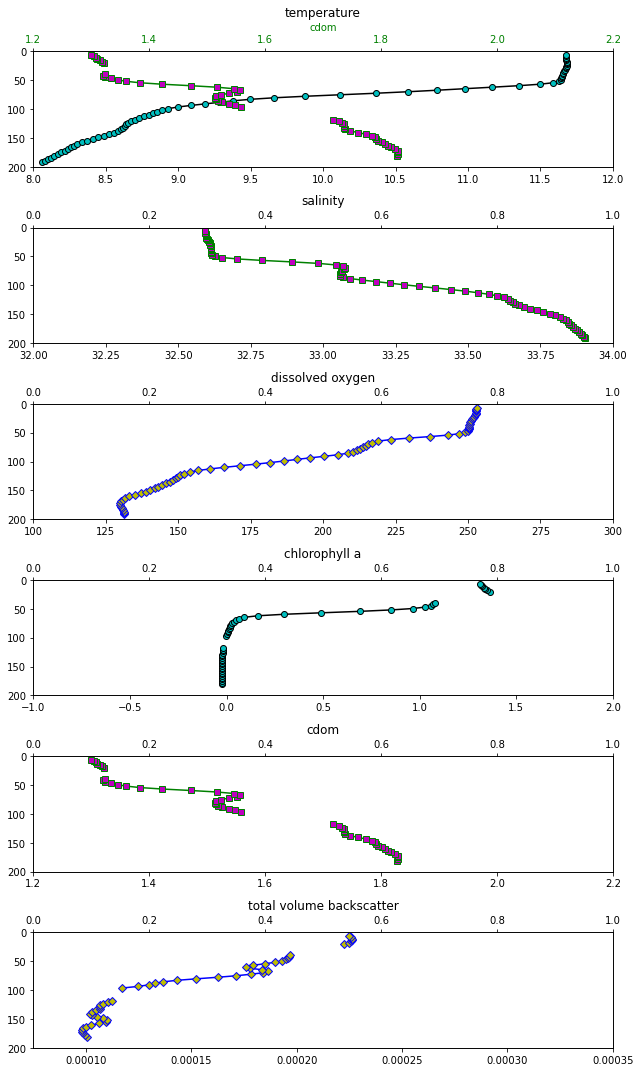

In [35]:
time0, time1 = dt64('2019-01-01T00:26:05'), dt64('2019-01-01T01:37:55')
ds_CTD_time_slice = ds_CTD.sel(time=slice(time0, time1))
ds_fluor_time_slice = ds_Fluorometer.sel(time=slice(time0, time1))

ctd_t = ds_CTD_time_slice['seawater_temperature'];       smooth_ctd_t = filter(ctd_t)
ctd_s = ds_CTD_time_slice['practical_salinity'];         smooth_ctd_s = filter(ctd_s)
ctd_o = ds_CTD_time_slice['corrected_dissolved_oxygen']; smooth_ctd_o = filter(ctd_o)

ctd_d = ds_CTD_time_slice['seawater_pressure']

fluor_a = ds_fluor_time_slice['fluorometric_chlorophyll_a'];          smooth_fluor_a = filter(fluor_a)
fluor_c = ds_fluor_time_slice['fluorometric_cdom'];                   smooth_fluor_c = filter(fluor_c)
fluor_s = ds_fluor_time_slice['total_volume_scattering_coefficient']; smooth_fluor_s = filter(fluor_s)

fluor_d = ds_fluor_time_slice['int_ctd_pressure']

temperature_lbound, temperature_ubound           =   8.,        12.
salinity_lbound, salinity_ubound                 =  32.,        34.
dissolved_oxygen_lbound, dissolved_oxygen_ubound = 100.,       300.
chlora_lbound, chlora_ubound                     =  -1.,         2.
cdom_lbound, cdom_ubound                         =   1.2,        2.2
scatt_lbound, scatt_ubound                       =   0.000075,    .00035

fig, axs = plt.subplots(6,1,figsize=(9, 15), tight_layout=True)

compare_unfiltered = False

if compare_unfiltered:
    axs[0].plot(ctd_t + 0.5, ctd_d, marker='o', markersize = 6., color='k', markerfacecolor='r')
    axs[1].plot(ctd_s + 0.5, ctd_d, marker='s', markersize = 6., color='g', markerfacecolor='r')
    axs[2].plot(ctd_o + 20., ctd_d, marker='D', markersize = 6., color='b', markerfacecolor='r')
    axs[3].plot(fluor_a + 0.5, fluor_d, marker='o', markersize = 6., color='k', markerfacecolor='r')
    axs[4].plot(fluor_c + 0.5, fluor_d, marker='s', markersize = 6., color='g', markerfacecolor='r')
    axs[5].plot(fluor_s + 20., fluor_d, marker='D', markersize = 6., color='b', markerfacecolor='r')

axs[0].plot(smooth_ctd_t, ctd_d, marker='o', markersize = 6., color='k', markerfacecolor='c')
axs[0].set(xlim = (temperature_lbound, temperature_ubound), ylim = (200., 0.), title='temperature')

axs[1].plot(smooth_ctd_s, ctd_d, marker='s', markersize = 6., color='g', markerfacecolor='m')
axs[1].set(xlim = (salinity_lbound, salinity_ubound), ylim = (200., 0.), title='salinity')

axs[2].plot(smooth_ctd_o, ctd_d, marker='D', markersize = 6., color='b', markerfacecolor='y')
axs[2].set(xlim = (dissolved_oxygen_lbound, dissolved_oxygen_ubound), ylim = (200., 0.), title='dissolved oxygen')

axs[3].plot(smooth_fluor_a, fluor_d, marker='o', markersize = 6., color='k', markerfacecolor='c')
axs[3].set(xlim = (chlora_lbound, chlora_ubound), ylim = (200., 0.), title='chlorophyll a')

axs[4].plot(smooth_fluor_c, fluor_d, marker='s', markersize = 6., color='g', markerfacecolor='m')
axs[4].set(xlim = (cdom_lbound, cdom_ubound), ylim = (200., 0.), title='cdom')

axs[5].plot(smooth_fluor_s, fluor_d, marker='D', markersize = 6., color='b', markerfacecolor='y')
axs[5].set(xlim = (scatt_lbound, scatt_ubound), ylim = (200., 0.), title='total volume backscatter')

# sets up companion plots with shared y-axis, independent 'twin' x-axis
axsTwin = [axs[i].twiny() for i in range(6)]
axsTwin[0].set_xlabel('cdom', color='g')
axsTwin[0].plot(smooth_fluor_c, fluor_d, marker='s', markersize = 6., color='g', markerfacecolor='m')
axsTwin[0].tick_params(axis='x', labelcolor='g')
axsTwin[0].set(xlim = (cdom_lbound, cdom_ubound), ylim = (200., 0.))

print('...')

## animating the time series

The following tries to make an animation by scrolling through all 278 profiles per above. I moved the charts around
to make the layout easier to see all at once; CTD on the left and Fluorometer on the right. 

### First segment

Do just temperature

### Second segment

Prior failed attempt

In [36]:
%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML, Video


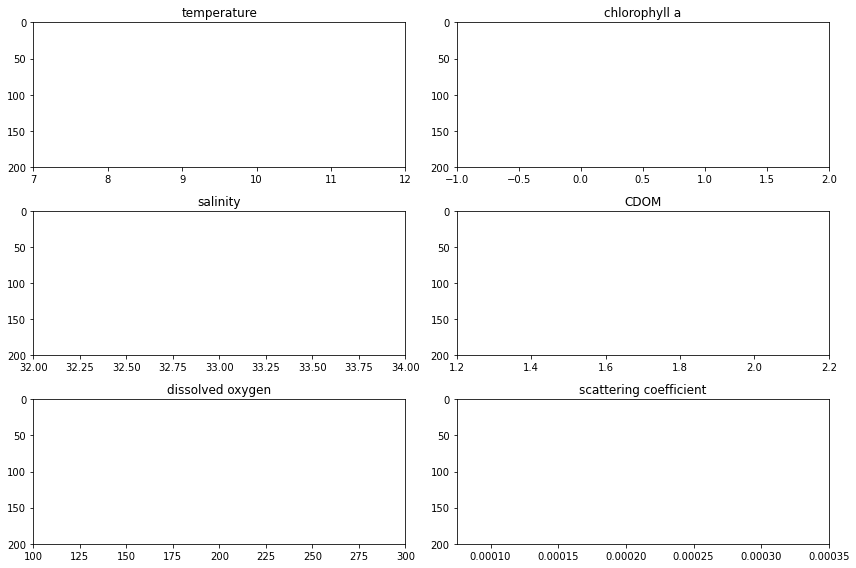

In [37]:
temperature_lbound, temperature_ubound           =   7.,        12.
salinity_lbound, salinity_ubound                 =  32.,        34.
dissolved_oxygen_lbound, dissolved_oxygen_ubound = 100.,       300.
chlora_lbound, chlora_ubound                     =  -1.,         2.
cdom_lbound, cdom_ubound                         =   1.2,        2.2
scatt_lbound, scatt_ubound                       =   0.000075,    .00035
pressure_lbound, pressure_ubound                 = 200.,         0.

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(3, 2, figsize=(12,8), tight_layout=True)

ax[0][0].set_xlim((temperature_lbound, temperature_ubound))
ax[1][0].set_xlim((salinity_lbound, salinity_ubound))
ax[2][0].set_xlim((dissolved_oxygen_lbound, dissolved_oxygen_ubound))
ax[0][1].set_xlim((chlora_lbound, chlora_ubound))
ax[1][1].set_xlim((cdom_lbound, cdom_ubound))
ax[2][1].set_xlim((scatt_lbound, scatt_ubound))

ax[0][0].set_title('temperature')
ax[1][0].set_title('salinity')
ax[2][0].set_title('dissolved oxygen')
ax[0][1].set_title('chlorophyll a')
ax[1][1].set_title('CDOM')
ax[2][1].set_title('scattering coefficient')

for n in range(3): 
    for m in range(2):
        ax[n][m].set_ylim((pressure_lbound, pressure_ubound))

# .plot() returns a tuple of length 1 so we de-reference this using the trailing [0]
line = [ax[0][0].plot([], [], lw=1, marker='o', ms = 6., c='xkcd:neon purple', mfc='xkcd:salmon pink')[0], \
        ax[1][0].plot([], [], lw=1, marker='s', ms = 6., c='xkcd:barney', mfc='xkcd:emerald')[0], \
        ax[2][0].plot([], [], lw=1, marker='D', ms = 6., c='xkcd:bronze', mfc='xkcd:orange brown')[0], \
        ax[0][1].plot([], [], lw=1, marker='p', ms = 6., c='xkcd:lime green', mfc='xkcd:deep pink')[0], \
        ax[1][1].plot([], [], lw=1, marker='v', ms = 6., c='xkcd:gold', mfc='xkcd:cherry red')[0], \
        ax[2][1].plot([], [], lw=1, marker='h', ms = 6., c='xkcd:tangerine', mfc='xkcd:bright sky blue')[0], \
       ]

# print(type(line), type(line[0]), 'first stop')

# initialization function: plot the background of each frame
def init():
    # print(type(line[0]))
    line[0].set_data([], [])
    line[1].set_data([], [])
    line[2].set_data([], [])
    line[3].set_data([], [])
    line[4].set_data([], [])
    line[5].set_data([], [])
    return line
    # was return (line0, line1,)

    
# animation function. This is called sequentially
def animated_chart(i):
    
    time0, time1 = dt64(ds_CTD.time[ascent_start_indices[i]].data), dt64(ds_CTD.time[ascent_end_indices[i]].data)
    
    ds_CTD_time_slice   =         ds_CTD.sel(time=slice(time0, time1))
    ds_fluor_time_slice = ds_Fluorometer.sel(time=slice(time0, time1))

    ctd_t = ds_CTD_time_slice['seawater_temperature'];       smooth_ctd_t = filter(ctd_t)
    ctd_s = ds_CTD_time_slice['practical_salinity'];         smooth_ctd_s = filter(ctd_s)
    ctd_o = ds_CTD_time_slice['corrected_dissolved_oxygen']; smooth_ctd_o = filter(ctd_o)

    ctd_d = ds_CTD_time_slice['seawater_pressure']

    fluor_a = ds_fluor_time_slice['fluorometric_chlorophyll_a'];          smooth_fluor_a = filter(fluor_a)
    fluor_c = ds_fluor_time_slice['fluorometric_cdom'];                   smooth_fluor_c = filter(fluor_c)
    fluor_s = ds_fluor_time_slice['total_volume_scattering_coefficient']; smooth_fluor_s = filter(fluor_s)

    fluor_d = ds_fluor_time_slice['int_ctd_pressure']

    # axs[0][0].plot(smooth_ctd_t, ctd_d, marker='o', markersize = 6., color='k', markerfacecolor='c')
    # axs[0][0].set(xlim = (temperature_lbound, temperature_ubound), ylim = (200., 0.), title='temperature')

    line[0].set_data(smooth_ctd_t, ctd_d)
    line[1].set_data(smooth_ctd_s, ctd_d)
    line[2].set_data(smooth_ctd_o, ctd_d)
    line[3].set_data(smooth_fluor_a, fluor_d)
    line[4].set_data(smooth_fluor_c, fluor_d)
    line[5].set_data(smooth_fluor_s, fluor_d)
   
    return line
    # was return (line0, line1,)

# call the animator. blit=True means only re-draw the parts that have changed.
# turned off while working elsewhere
if False:
    anim = animation.FuncAnimation(fig, animated_chart, init_func=init, frames=278, interval=100, blit=True, repeat=False)
    HTML(anim.to_html5_video())


In [ ]:
# ani = animation.FuncAnimation(fig, MakeChart, interval=50, frames=15, repeat=True, blit=True) # frames > 278
anim.save('./osb_temp.mp4')    # prior code added , writer=writer)

In [10]:
Video("./osb_temp.mp4")           # can include embed=True

In [1]:
from IPython.display import Video
Video("./osb_temp.mp4", embed=True)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Data charting part 2: slider selection of profiles

This section takes the above results and provides a slider to drag through all 278 profiles in January 2019.

To see differentiation of these curves: Drop down to the next segment.

In [38]:
from ipywidgets import *
from traitlets import dlink

In [53]:
def ProfileChoicesChart(ctd, fluor, t, nf = 1):
    """
    Left/Right chart comparative: CTD x 3, fluorescence x 3; using time ranges in t[0, 1, 2, 3][i]; 
      using the 'hat' filter with param nf
    """
    
    print(len(t[0]), len(t[1]), len(t[2]), len(t[3]))
    
    nlr = [len(t[0]), len(t[2])]
    
    # t is a list of four lists so the slow / left index refers as 0, 1, 2, 3 to:
    #   left begin-time, left end-time, right begin-time, right end-time
    # Each of these four elements is a list of times corresponding to multiple profiles
    #   By choosing a slider value > 1 we can overplot sets of consecutive profiles
    
    nLeft = len(t[0])
    if not nLeft == len(t[1]): print('profile count mismatch left side'); return
    nRight = len(t[2])
    if not nRight == len(t[3]): print('profile count mismatch right side'); return
    
    temperature_lbound, temperature_ubound           =   8.,        12.
    salinity_lbound, salinity_ubound                 =  32.,        34.
    dissolved_oxygen_lbound, dissolved_oxygen_ubound = 100.,       300.
    chlora_lbound, chlora_ubound                     =  -1.,         2.
    cdom_lbound, cdom_ubound                         =   1.2,        2.2
    scatt_lbound, scatt_ubound                       =   0.000075,    .00035

    fig, axs = plt.subplots(6,2,figsize=(16, 15), tight_layout=True)

    for lr in range(2):                           # lr = 0 for left, 1 for right
        for side_counter in range(nlr[lr]):       # side_counter counts first lefts then rights
        
            # these span across sensors for each (index = 'side_counter') time window
            ctd_slice   = ctd.sel(time=slice(t[lr*2][side_counter], t[lr*2+1][side_counter]))
            fluor_slice = fluor.sel(time=slice(t[lr*2][side_counter], t[lr*2+1][side_counter]))

            # ctd, fluor breakout into source sensor data
            ctd_t   =   ctd_slice['seawater_temperature']
            ctd_s   =   ctd_slice['practical_salinity']
            ctd_o   =   ctd_slice['corrected_dissolved_oxygen']
            fluor_a = fluor_slice['fluorometric_chlorophyll_a']
            fluor_c = fluor_slice['fluorometric_cdom']
            fluor_s = fluor_slice['total_volume_scattering_coefficient']

            # generate filtered versions (to do include varying filter parameters)
            ctd_t_filt   = filter(  ctd_t, 'hat', nf)
            ctd_s_filt   = filter(  ctd_s, 'hat', nf)
            ctd_o_filt   = filter(  ctd_o, 'hat', nf)
            fluor_a_filt = filter(fluor_a, 'hat', nf)
            fluor_c_filt = filter(fluor_c, 'hat', nf)
            fluor_s_filt = filter(fluor_s, 'hat', nf)

            ctd_d   = ctd_slice['seawater_pressure']
            fluor_d = fluor_slice['int_ctd_pressure']

            axs[0][lr].plot(  ctd_t_filt,   ctd_d, marker='o', markersize = 4., color='k', markerfacecolor='c')
            axs[1][lr].plot(  ctd_s_filt,   ctd_d, marker='s', markersize = 4., color='g', markerfacecolor='m')
            axs[2][lr].plot(  ctd_o_filt,   ctd_d, marker='D', markersize = 4., color='b', markerfacecolor='y')   
            axs[3][lr].plot(fluor_a_filt, fluor_d, marker='o', markersize = 4., color='k', markerfacecolor='c')
            axs[4][lr].plot(fluor_c_filt, fluor_d, marker='s', markersize = 4., color='g', markerfacecolor='m')
            axs[5][lr].plot(fluor_s_filt, fluor_d, marker='D', markersize = 4., color='b', markerfacecolor='y')

        axs[0][lr].set(xlim = (temperature_lbound, temperature_ubound),           ylim = (200., 0.), title='temperature')
        axs[1][lr].set(xlim = (salinity_lbound, salinity_ubound),                 ylim = (200., 0.), title='salinity')
        axs[2][lr].set(xlim = (dissolved_oxygen_lbound, dissolved_oxygen_ubound), ylim = (200., 0.), title='dissolved oxygen')
        axs[3][lr].set(xlim = (chlora_lbound, chlora_ubound),                     ylim = (200., 0.), title='chlorophyll a')
        axs[4][lr].set(xlim = (cdom_lbound, cdom_ubound),                         ylim = (200., 0.), title='cdom')
        axs[5][lr].set(xlim = (scatt_lbound, scatt_ubound),                       ylim = (200., 0.), title='backscatter')
    
    print('left profile', str(t[0][0])[:16], 'to', str(t[1][-1])[:16], \
          '    ...      right profile', str(t[2][0])[:16], 'to', str(t[3][-1])[:16])
    
    return

fLeft0, fRight0 = 0, 0
nLeft0, nRight0 = 1, 1

nProfiles = len(ascent_start_indices)

def SliderRelay(firstLeft, numberLeft, firstRight, numberRight):
    
    global ds_CTD, ds_Fluorometer, nProfiles, ascent_start_indices, ascent_end_indices 
    
    nLeftActual  = min(numberLeft, nProfiles - firstLeft)
    nRightActual = min(numberRight, nProfiles - firstRight)
    
    t_left_start_list  = [dt64(ds_CTD.time[ascent_start_indices[i]].data) \
                          for i in range(firstLeft, firstLeft + nLeftActual)]
    t_left_end_list    = [dt64(ds_CTD.time[ascent_end_indices[i]].data) \
                          for i in range(firstLeft, firstLeft + nLeftActual)]   
    t_right_start_list = [dt64(ds_CTD.time[ascent_start_indices[i]].data) \
                          for i in range(firstRight, firstRight + nRightActual)]
    t_right_end_list   = [dt64(ds_CTD.time[ascent_end_indices[i]].data) \
                          for i in range(firstRight, firstRight + nRightActual)]
    
    ProfileChoicesChart(ds_CTD, ds_Fluorometer, 
                        [t_left_start_list, t_left_end_list, 
                         t_right_start_list, t_right_end_list], 
                        1)


interact(SliderRelay, firstLeft=widgets.IntSlider(min=0, max=nProfiles-1, step=1, value=fLeft0, \
                                          continuous_update=False, description='1st prof left'), \
                      numberLeft=widgets.IntSlider(min=1, max=nProfiles-1, step=1, value=nLeft0, \
                                          continuous_update=False, description='n-prof left'), \
                      firstRight=widgets.IntSlider(min=0, max=nProfiles-1, step=1, value=fRight0, \
                                       continuous_update=False, description='1st prof right'), \
                      numberRight=widgets.IntSlider(min=1, max=nProfiles-1, step=1, value=nRight0, \
                                          continuous_update=False, description='n-prof right')\
        )
               


interactive(children=(IntSlider(value=0, continuous_update=False, description='1st prof left', max=277), IntSl…

<function __main__.SliderRelay(firstLeft, numberLeft, firstRight, numberRight)>

## differentiation of profile curves

The idea here is to look at first and second derivatives as a way of characterizing / segmenting profiles.

[(-1.0, 6.0), (200.0, 0.0)]

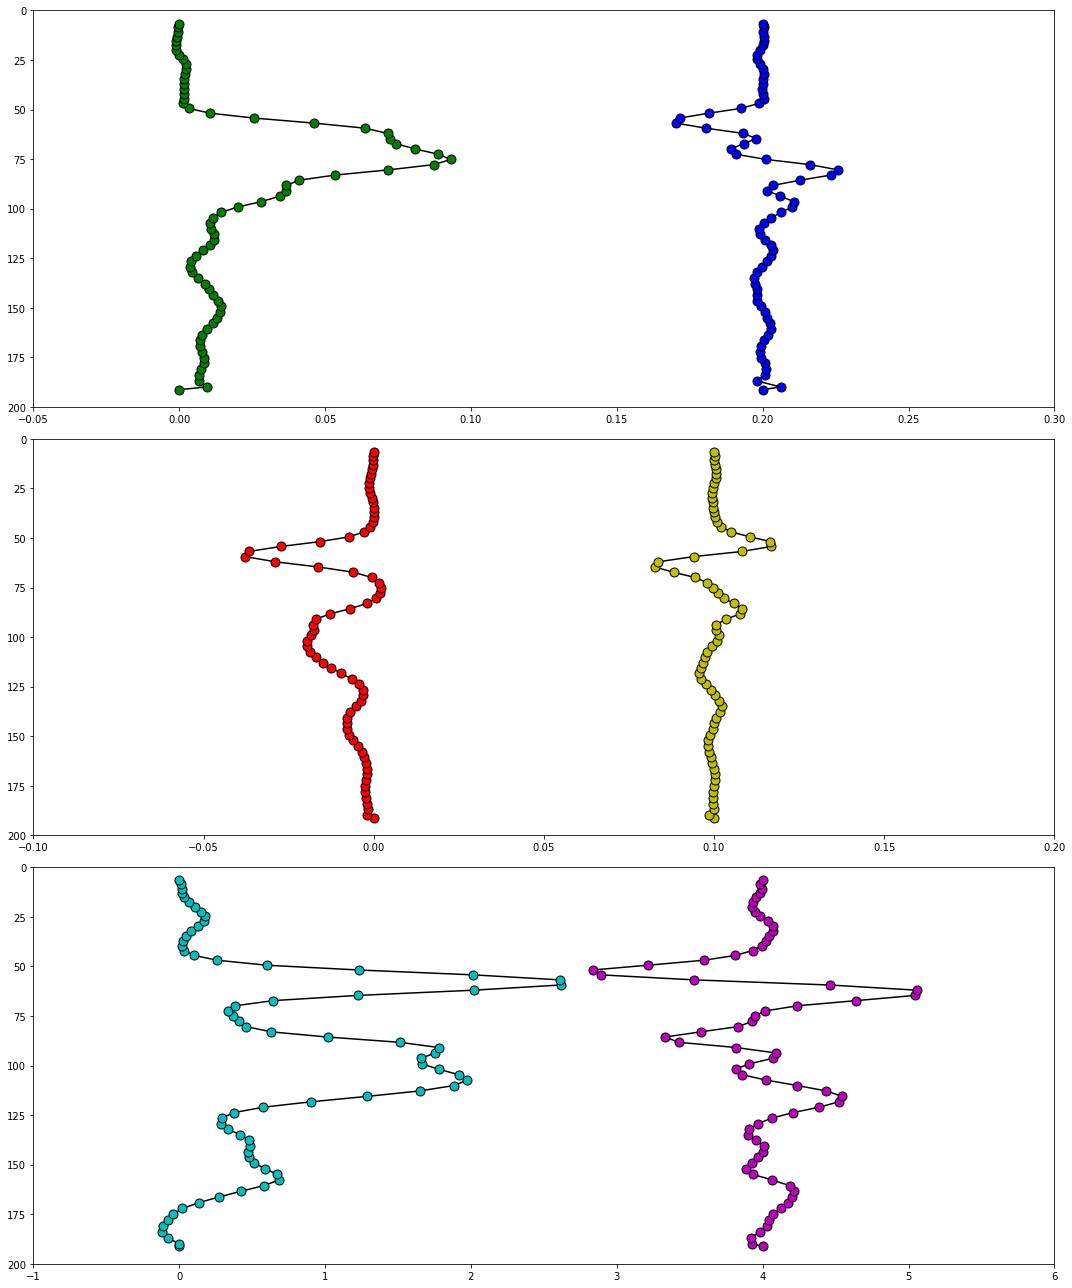

In [7]:
dydx1_t = dydx(smooth_t, sensor_d)
dydx2_t = dydx(dydx1_t, sensor_d)
dydx1_s = dydx(smooth_s, sensor_d)
dydx2_s = dydx(dydx1_s, sensor_d)
dydx1_o = dydx(smooth_o, sensor_d)
dydx2_o = dydx(dydx1_o, sensor_d)

fig, axs = plt.subplots(3,1,figsize=(15,18), tight_layout=True)

axs[0].plot(dydx1_t, sensor_d, marker='o', markersize = 9., color='k', markerfacecolor='g')
axs[0].plot(dydx2_t*np.ones(71)*4+0.2, sensor_d, marker='o', markersize = 9., color='k', markerfacecolor='b')
axs[0].set(xlim = (-.05, .3), ylim = (200., 0.))

axs[1].plot(dydx1_s, sensor_d, marker='o', markersize = 9., color='k', markerfacecolor='r')
axs[1].plot(dydx2_s*np.ones(71)*4+0.1, sensor_d, marker='o', markersize = 9., color='k', markerfacecolor='y')
axs[1].set(xlim = (-.1, .2), ylim = (200., 0.))

axs[2].plot(dydx1_o, sensor_d, marker='o', markersize = 9., color='k', markerfacecolor='c')
axs[2].plot(dydx2_o*np.ones(71)*4+4., sensor_d, marker='o', markersize = 9., color='k', markerfacecolor='m')
axs[2].set(xlim = (-1, 6.), ylim = (200., 0.))


In [8]:
sensor_d[-1]

<xarray.DataArray 'seawater_pressure' ()>
array(6.618323)
Coordinates:
    time     datetime64[ns] 2019-01-01T01:37:00
Attributes:
    comment:                  Seawater Pressure refers to the pressure exerte...
    long_name:                Seawater Pressure
    precision:                3
    data_product_identifier:  PRESWAT_L1
    standard_name:            sea_water_pressure
    units:                    dbar
    ancillary_variables:      pressure,pressure_temp
    axis:                     Z

## Profile as a class

The idea here is to create a Python class 'Profile' that can be used to organize many profiles.

In [9]:
class Profile:
    """A water column profile"""
    
    def __init__(self, t0='2019-01-01T00:26:05', t1='2019-01-01T01:37:55', d0=191.268063, d1=6.618323, site='osb'):
        self.t0 = dt64(t0)
        self.t1 = dt64(t1)
        self.d0 = d0
        self.d1 = d1
        self.site = site

    def readout(self):
        print("Profile start", self.t0, 'duration', self.t1 - self.t0)

p = Profile()
p.readout()

Profile start 2019-01-01T00:26:05 duration 4310 seconds


## How many profiles ran in January 2019?

At nine per day and 31 days we should have 279 profiles. The Crawler finds only 278 so either the
algorithm is faulty or a profile was skipped. By looking at the depth chart we see it is the latter case. 

IndexError: index 16 is out of bounds for axis 0 with size 16

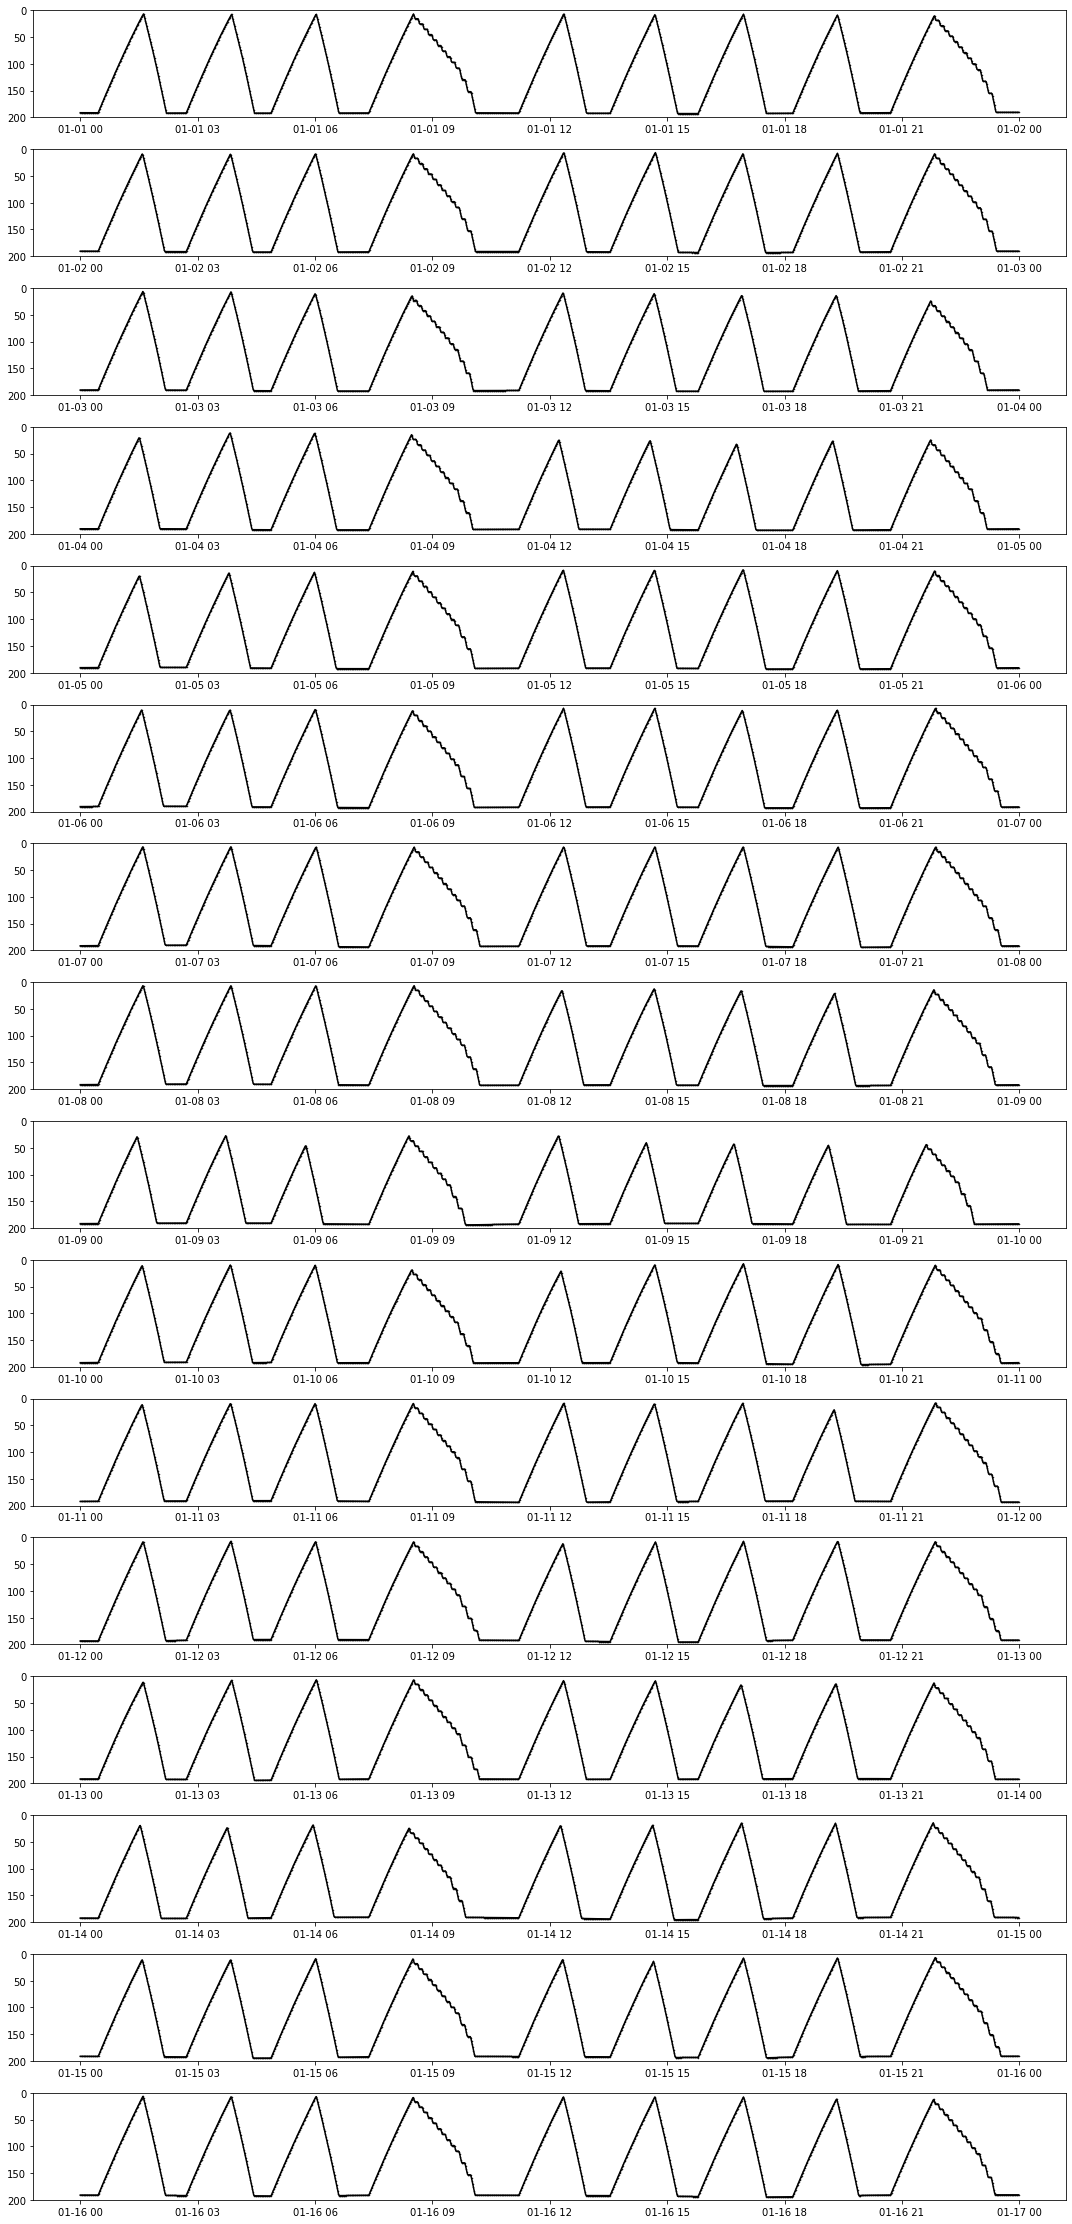

In [10]:
# January 2019 has all but one profile correct (278 / 279 possible). 
#   Missing is the last profile of the month.
# For each given UTC day: Profiles 4 and 9 are pH profiles.
#   Could use time window criteria: Hour on [6, 10] and [19, 23].

fig, axs = plt.subplots(16, 1, figsize=(15,31), tight_layout=True)

for i in range(31):
    daystring = str(i+1) if i > 8 else '0' + str(i+1)
    time0, time1 = '2019-01-' + daystring + 'T00:00:00', '2019-01-' + daystring + 'T23:59:59'
    ds = ds_CTD.sel(time=slice(time0, time1))
    axs[i].plot(ds.time, ds.seawater_pressure, marker='.', markersize=1., color='k')
    axs[i].set(ylim = (200., 0.))

print('...January 2019 OSB depth profiles...')